In [146]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

proj_dir = os.path.join(os.pardir,os.pardir)
data_dir = os.path.join(proj_dir,'data')
int_dir = os.path.join(data_dir,'analysis','interim')
fig_dir = os.path.join(proj_dir,'reports','figures','tmp')

src_dir = os.path.join(proj_dir,'src')
sys.path.append(src_dir)

from tools.log_progress import log_progress

grid_path = os.path.join(int_dir,'grd2_dV.nc')
m_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_m.nc')
temp_path = os.path.join(data_dir,'analysis','raw','waom2','ocean_avg_0538-0610_temp.nc')
shelves_path = os.path.join(data_dir,'analysis','interim','shelves2.npy')
sec_path = os.path.join(int_dir,'mask_sector2.npy')
shelf_sec_path = os.path.join(int_dir,'mask_shelf_sector2.npy')

In [10]:
from dask.distributed import Client
c = Client()
c

Client Scheduler: tcp://127.0.0.1:45968 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 16 Cores: 16 Memory: 101.38 GB


In [147]:
grd = xr.open_dataset(grid_path)
m = xr.open_dataset(m_path).m
temp = xr.open_dataset(temp_path,chunks={'xi_rho':1000,'eta_rho':1000,'s_rho':2,'ocean_time':1}).temp

shelves = np.load(shelves_path).item()
mask_sector = np.load(sec_path).item()
mask_sector_shelf = np.load(shelf_sec_path).item()

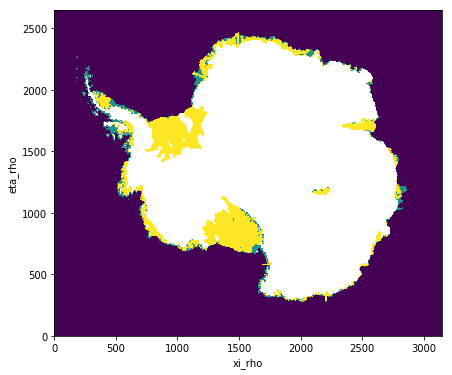

In [152]:
%matplotlib inline

depth = -200

depth_mask = grd.mask_rho.copy()
depth_mask.values[grd.zice == 0.0] = 0

depth_mask.values[(grd.zice < depth) & (grd.mask_rho ==1)] = 2

plt.close()
fig,ax = plt.subplots(figsize=(9,6))
depth_mask.where(grd.mask_rho).plot(ax=ax,add_colorbar=False)
ax.set_aspect('equal')
#for k,v in mask_sector.items():
#    ax.contour(v,colors=('black'),linewidths=0.01)
#ax.set_xticks([])
#ax.set_yticks([])
#plt.savefig(os.path.join(fig_dir,'depth_mask.png'))
plt.show()

In [153]:
shallow_melt = {}
deep_melt = {}
s2a = 365*24*3600
for key,sec_mask in mask_sector.items():
    print(key)
    mask_shallow = (depth_mask == 1) & (sec_mask == 1)
    mask_deep = (depth_mask == 2) & (sec_mask == 1)
    
    shallow_melt[key] = m[:,0,0]
    deep_melt[key] = m[:,0,0]
    
    for i,time in log_progress(enumerate(m.ocean_time),every=2,name='time steps'): 
        shallow_melt[key][i] = m[i].where(mask_shallow).mean(['xi_rho','eta_rho'])*s2a
        deep_melt[key][i] = m[i].where(mask_deep).mean(['xi_rho','eta_rho'])*s2a

Total Antarctica


Western East Antarctica


Amery/Prydz Bay


Sabrina Coast/Aurora subglacial basin


George V Coast/Wilkes subglacial basin


Ross Sea


Amundsen Sea


Bellingshausen Sea


Weddell Sea


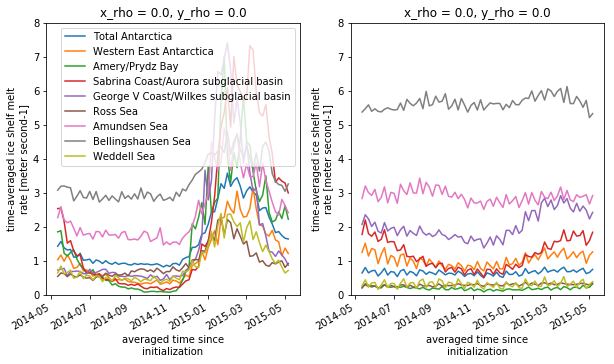

In [46]:
plt.close()
fig,axes = plt.subplots(ncols=2,figsize=(10,5))
ax1,ax2 = axes.flatten()
for key,data in shallow_melt.items():
    data.plot(ax=ax1,label=key)
ax1.legend()
ax1.set_ylim(0,8)

for key,data in deep_melt.items():
    data.plot(ax=ax2,label=key)
ax2.set_ylim(0,8)
plt.show()


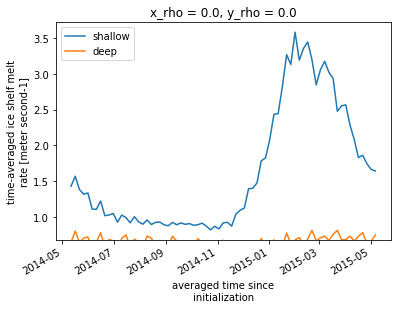

In [48]:
plt.close()
fig,ax = plt.subplots()
shallow_melt['Total Antarctica'].plot(ax=ax,label='shallow')
deep_melt['Total Antarctica'].plot(ax=ax,label='deep')
ax.legend()
plt.show()

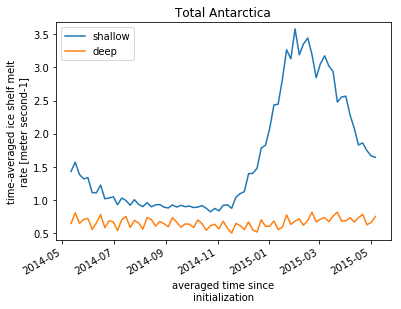

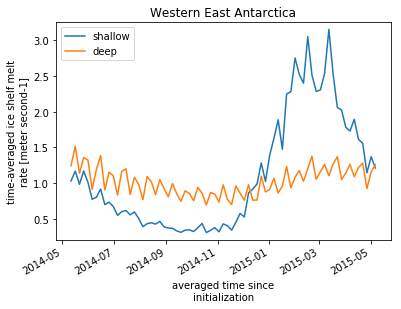

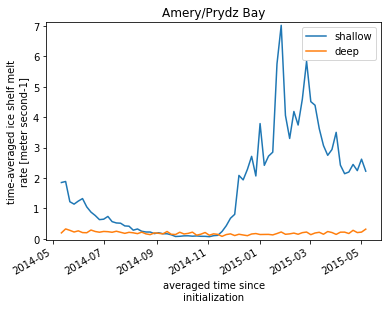

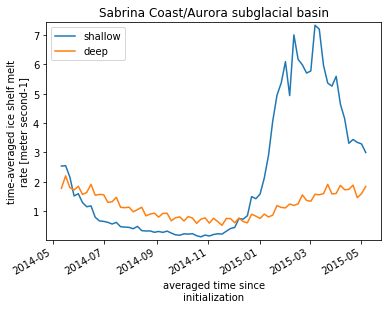

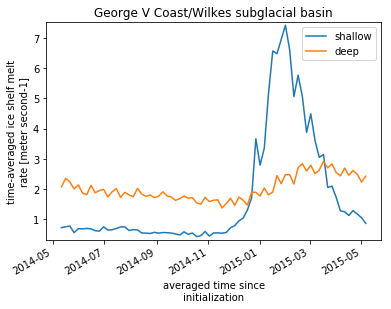

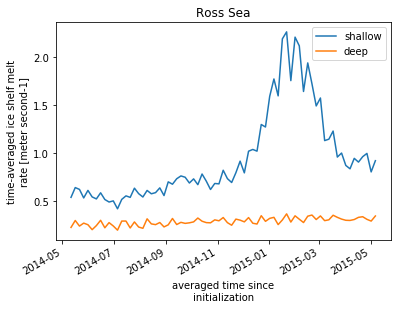

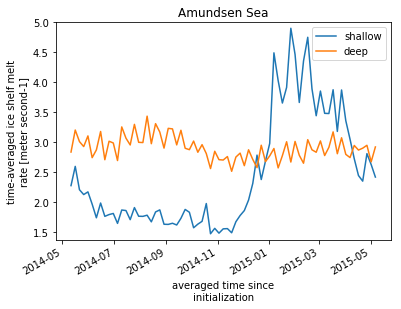

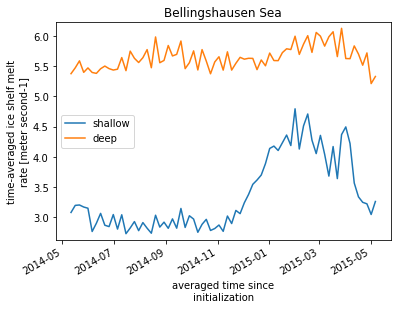

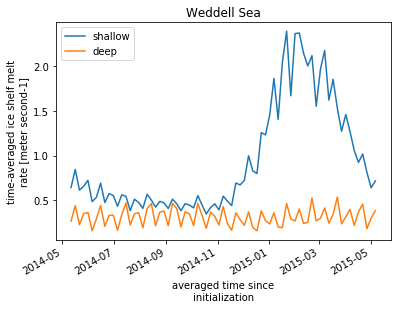

In [154]:
plt.close()
for key,data in shallow_melt.items():
    fig,ax = plt.subplots()
    shallow_melt[key].plot(ax=ax,label='shallow')
    deep_melt[key].plot(ax=ax,label='deep')
    ax.legend()
    y_min = min(deep_melt[key].min(),shallow_melt[key].min())-0.1
    y_max = max(deep_melt[key].max(),shallow_melt[key].max())+0.1
    ax.set_ylim(y_min,y_max)
    ax.set_title(key)
    plt.savefig(os.path.join(fig_dir,'melt_shallow_deep_'+key.replace('/','_')+'_.png'))

In [4]:
mask_shallow_WEA = (grd.z > -200) & (mask_sector_shelf['Western East Antarctica'] == 1)
xi_min = grd.xi_rho.where(mask_shallow_WEA).min().values.astype(int)-1
xi_max = grd.xi_rho.where(mask_shallow_WEA).max().values.astype(int)+1

eta_min = grd.eta_rho.where(mask_shallow_WEA).min().values.astype(int)-1
eta_max = grd.eta_rho.where(mask_shallow_WEA).max().values.astype(int)+1

sel = {'xi_rho':slice(xi_min,xi_max),'eta_rho':slice(eta_min,eta_max)}
mask = mask_shallow_WEA[sel]

In [12]:
temp_shallow_WEA = temp[:,0,0,0].load()
for i,time in log_progress(enumerate(temp.ocean_time),every=2,name='time steps'):
    temp_shallow_WEA[i] = temp[i][sel].where(mask).mean(['xi_rho','eta_rho','s_rho'])*1.0

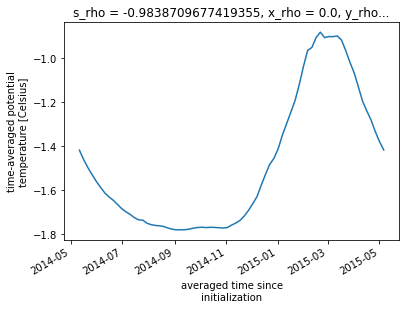

In [14]:
plt.close()
fig,ax = plt.subplots()
temp_shallow_WEA.plot(ax=ax)
plt.show()

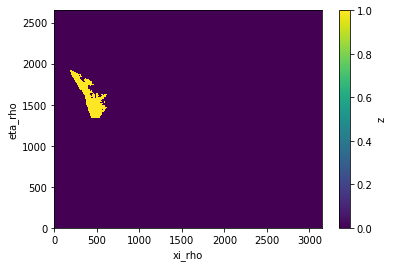

In [73]:
mask = (grd.z >= -300) & (mask_sector_shelf["Bellingshausen Sea"])

plt.close()
mask[30].plot()
plt.show()

In [107]:
mask_sector_shelf.keys()

dict_keys(['Total Antarctica', 'Western East Antarctica', 'Amery/Prydz Bay', 'Sabrina Coast/Aurora subglacial basin', 'George V Coast/Wilkes subglacial basin', 'Ross Sea', 'Amundsen Sea', 'Bellingshausen Sea', 'Weddell Sea'])

In [138]:
sel_dict = {k: mask_sector[k] for k in ['Sabrina Coast/Aurora subglacial basin', 'George V Coast/Wilkes subglacial basin', 'Ross Sea', 'Amundsen Sea', 'Bellingshausen Sea', 'Weddell Sea']}

Total Antarctica


Western East Antarctica


Amery/Prydz Bay


Sabrina Coast/Aurora subglacial basin


George V Coast/Wilkes subglacial basin


Ross Sea


Amundsen Sea


Bellingshausen Sea


Weddell Sea


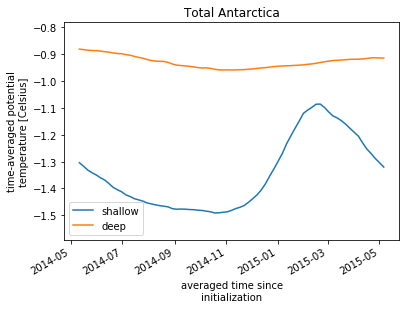

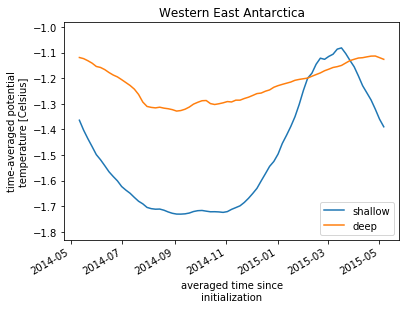

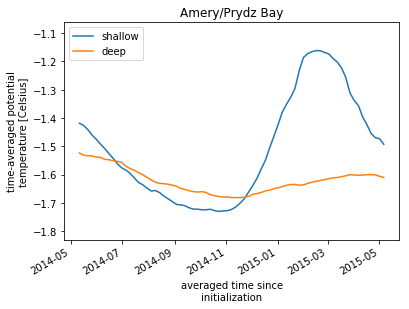

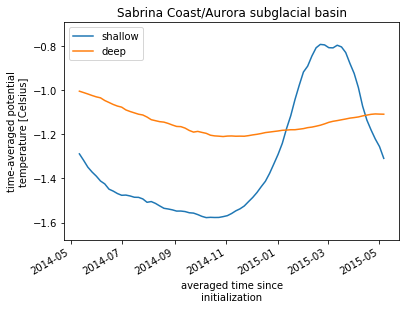

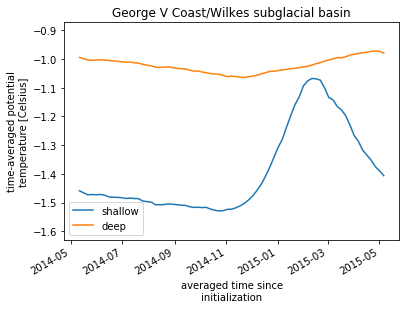

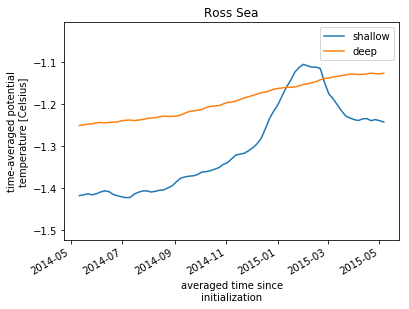

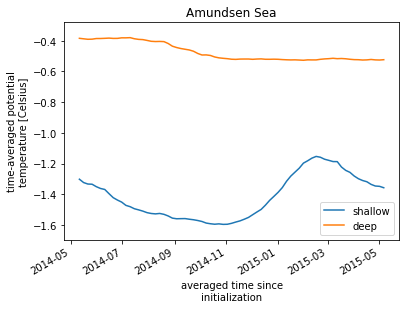

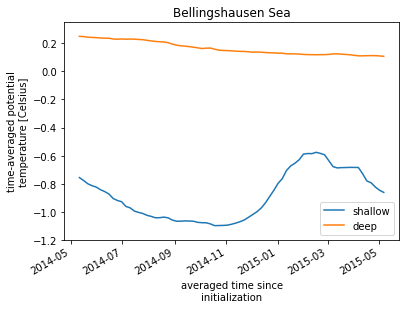

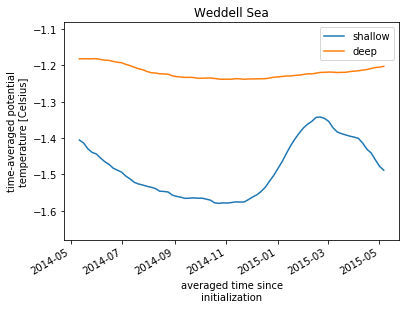

In [156]:
shallow_temp = {}
deep_temp = {}
for key,sec_mask in mask_sector.items():
    
    print(key)
    
    mask_shelf = (sec_mask == 1) & (mask_sector_shelf['Total Antarctica'] == 1)
    mask_shallow = (grd.z >= depth) & mask_shelf
    mask_deep = (grd.z < depth) & mask_shelf
    
    xi_min = grd.xi_rho.where(mask_shelf).min().values.astype(int)-1
    xi_max = grd.xi_rho.where(mask_shelf).max().values.astype(int)+1

    eta_min = grd.eta_rho.where(mask_shelf).min().values.astype(int)-1
    eta_max = grd.eta_rho.where(mask_shelf).max().values.astype(int)+1

    sel = {'xi_rho':slice(xi_min,xi_max),'eta_rho':slice(eta_min,eta_max)}
    
    mask_shallow = mask_shallow[sel]
    mask_deep = mask_deep[sel]

    shallow_temp[key] = temp[:,0,0,0].load()
    deep_temp[key] = temp[:,0,0,0].load()
    
    dV = grd[sel].dV.where(mask_shallow)
    weights = dV/dV.sum()

    for i,time in log_progress(enumerate(temp.ocean_time),every=2,name='time steps'): 
        shallow_temp[key][i] = (temp[i][sel].where(mask_shallow)*weights).sum().load()
        
        
    dV = grd[sel].dV.where(mask_deep)
    weights = dV/dV.sum()

    for i,time in log_progress(enumerate(temp.ocean_time),every=2,name='time steps'): 
        deep_temp[key][i] = (temp[i][sel].where(mask_deep)*weights).sum().load()
        
    fig,ax = plt.subplots()
    shallow_temp[key].plot(ax=ax,label='shallow')
    deep_temp[key].plot(ax=ax,label='deep')
    ax.legend()
    y_min = min(deep_temp[key].min(),shallow_temp[key].min())-0.1
    y_max = max(deep_temp[key].max(),shallow_temp[key].max())+0.1
    ax.set_ylim(y_min,y_max)
    ax.set_title(key)
    plt.savefig(os.path.join(fig_dir,'temp_shallow_deep_'+key.replace('/','_')+'_.png'))

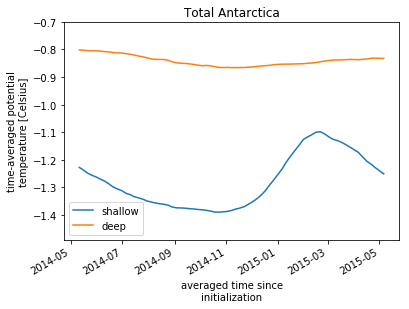

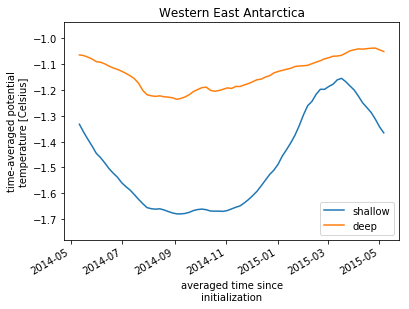

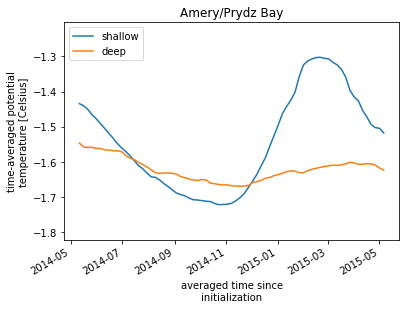

In [127]:
plt.close()
for key,data in shallow_temp.items():
    fig,ax = plt.subplots()
    shallow_temp[key].plot(ax=ax,label='shallow')
    deep_temp[key].plot(ax=ax,label='deep')
    ax.legend()
    y_min = min(deep_temp[key].min(),shallow_temp[key].min())-0.1
    y_max = max(deep_temp[key].max(),shallow_temp[key].max())+0.1
    ax.set_ylim(y_min,y_max)
    ax.set_title(key)
    plt.savefig(os.path.join(fig_dir,'temp_shallow_deep_'+key.replace('/','_')+'_.png'))

In [112]:
xi,eta = np.meshgrid(grd.xi_rho,grd.eta_rho)

In [124]:
grd.xi_rho.where(mask).min()

<xarray.DataArray ()>
array(2569.)

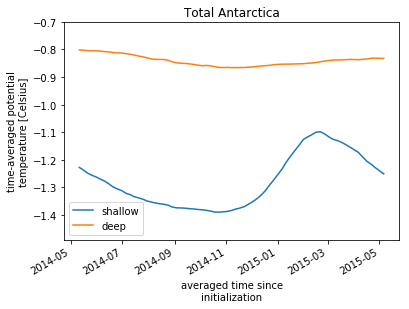

In [88]:
key = 'Total Antarctica'
plt.close()
fig,ax1 = plt.subplots()
#ax1,ax2 = axes.flatten()
y_min = min(deep_temp[key].min(),shallow_temp[key].min())-0.1
y_max = max(deep_temp[key].max(),shallow_temp[key].max())+0.1
ax1.set_ylim(y_min,y_max)
shallow_temp[key].plot(ax=ax1,label='shallow')
deep_temp[key].plot(ax=ax1,label='deep')
ax1.legend()
ax1.set_title(key)
plt.savefig(os.path.join(fig_dir,'temp_shallow_deep_'+key.replace('/','_')+'_.png'))
plt.show()

In [36]:
temp_shallow_WEA

<xarray.DataArray ()>
array(-1.336573)
Coordinates:
    ocean_time  datetime64[ns] 2014-05-11T12:00:00

In [ ]:
mask_shallow = mask_sector['Western East Antarctica'] & (grd.zice > -200)
test_area = grd.mask_rho.where(mask_sector['Western East Antarctica'] & grd.zice > -200))

In [109]:

m_shallow = m.where(shelves['Wilkins']['mask']).mean(['xi_rho','eta_rho'])
m_deep = m.where(shelves['George VI']['mask']).mean(['xi_rho','eta_rho'])

In [128]:
s2a = 365*24*3600
mask_deep_B = ((mask_deep==1) & (mask_sector["Bellingshausen Sea"]))[sel]
mask_shallow_B = ((mask_deep==2) & (mask_sector["Bellingshausen Sea"]))[sel]

m_shallow_B = m[sel].where(mask_shallow_B).mean(['xi_rho','eta_rho'])*s2a
m_deep_B = m[sel].where(mask_deep_B).mean(['xi_rho','eta_rho'])*s2a

In [129]:
m_deep_B

<xarray.DataArray (ocean_time: 73, s_rho: 31)>
array([[ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan]])
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2014-05-11T12:00:00 ...
Dimensions without coordinates: s_rho

No handles with labels found to put in legend.


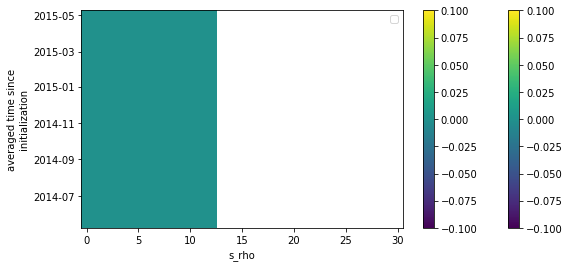

In [130]:
plt.close()
fig,ax = plt.subplots(figsize=(9,4))
(m_shallow_B-m_shallow_B.mean()).plot(ax=ax,label='shallow')
(m_deep_B-m_deep_B.mean()).plot(ax=ax,label='deep')
ax.legend()
plt.show()

In [4]:
mask_shelf = mask_sector_shelf['Total Antarctica']
mask_cavity = grd.zice < 0.0

In [5]:
mask_Bel = mask_shelf & mask_sector['Bellingshausen Sea']

In [20]:
sel = {'xi_rho':slice(0,1000),'eta_rho':slice(1000,2000)}

In [40]:
mask_shallow = mask_Bel & (grd.z > -200)
mask = mask_shallow[sel]
    
dV = grd[sel].dV.where(mask)
weights = dV/dV.sum()

In [46]:
temp_shallow = (temp[sel].where(mask)*weights).sum(['xi_rho','eta_rho','s_rho']).load()

In [72]:
mask_deep = mask_Bel & (grd.z <= -400)

mask = mask_deep[sel]

dV = grd[sel].dV.where(mask)
weights = dV/dV.sum()

temp_deep = (temp[sel].where(mask)*weights).sum(['xi_rho','eta_rho','s_rho']).load()

<IPython.core.display.Javascript object>


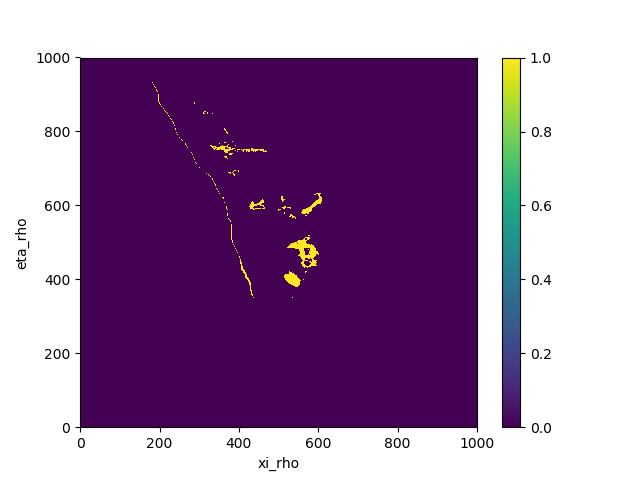

In [71]:
%matplotlib notebook
mask_deep = mask_Bel & (grd.z <= -400)
plt.close()
mask_deep[:,:,10][sel].plot()
plt.show()

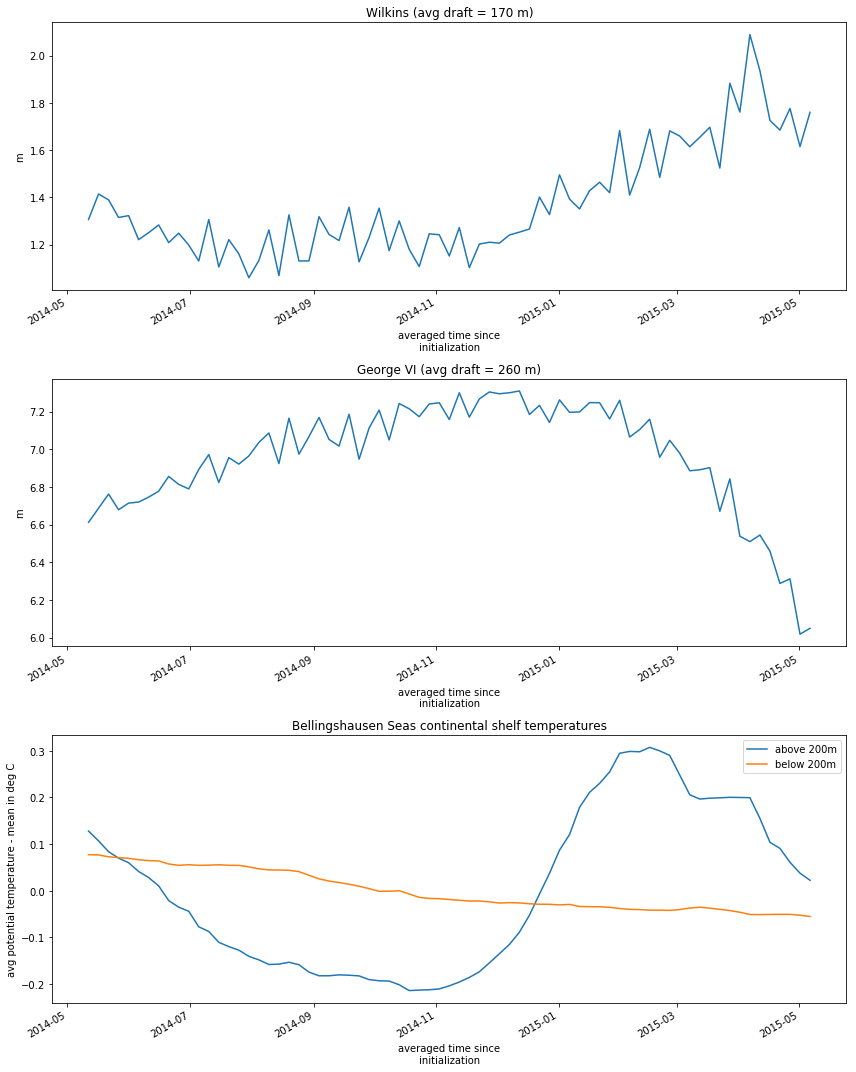

In [103]:
%matplotlib inline
plt.close()
fig,[ax1,ax2,ax3] = plt.subplots(nrows=3,figsize=(12,15))

((m_shallow)*s2a).plot(ax=ax1,label='Wilkins (avg draft = 170 m)')
((m_deep)*s2a).plot(ax=ax2,label='George VI (avg draft = 260 m)')
#ax2.set_ylabel('avg melting - mean in m/yr')
ax1.set_title('Wilkins (avg draft = 170 m)')
ax2.set_title('George VI (avg draft = 260 m)')
#ax1.set_ylim(-1,1)
#ax1.legend()
(temp_shallow-temp_shallow.mean()).plot(ax=ax3,label='above 200m')
(temp_deep-temp_deep.mean()).plot(ax=ax3,label='below 200m')
ax3.set_ylabel('avg potential temperature - mean in deg C')
ax3.set_title('Bellingshausen Seas continental shelf temperatures')
ax3.legend()
plt.tight_layout()
plt.show()

In [77]:
plt.close()

In [38]:
mask_shallow = mask_Bel & (grd.z > -200)
mask = mask_shallow[sel]
    
dV = grd[sel].dV.where(mask)
weights = dV/dV.sum()
temp_shallow = temp.isel(eta_rho=0,xi_rho=0,s_rho=0)
for i,time in log_progress(enumerate(temp.ocean_time),every=2):
    
    temp_shallow[i] = (temp.sel(ocean_time=time)[sel].where(mask)*weights).sum().values*1.0

TypeError: this variable's data is stored in a dask array, which does not support item assignment. To assign to this variable, you must first load it into memory explicitly using the .load() method or accessing its .values attribute.

In [31]:
temp_deep

-64.51050055487393

In [73]:
mask = mask_Bel & (grd.z > -200)
    
dV = grd.dV.where(mask)
weights = dV/dV.sum()

temp_shallow = (temp.where(mask)*weights).sum().values*1.0

MemoryError: 